# Network Measurements and Data Analysis Lab Homework 2
The goal of this homework is to implement and test a website fingerprinting approach able to classify what website is visited by a user observing only encrypted HTTPS traffic.
Our approach will involve the following steps:

1. Gathering the Data
2. Extract the Biflow Features and Construct the Dataset
3. Testing the k-NN and Analyzing the Results
4. Using an Alternate Test Set

Let's get started!

## 1. Gathering the Data

### 1.1 Initial Insight
Before diving into the problem we have think about how does the HTTPS fringerprinting work and what are the valueable features.

HTTPS fingerprinting typically involves analyzing the packet headers and metadata to identify the specific encryption and authentication protocols used in the HTTPS connection.

Some of the key protocols that are commonly analyzed in HTTPS fingerprinting include:

1. SSL/TLS: SSL/TLS (Secure Sockets Layer/Transport Layer Security) is the encryption protocol used in HTTPS to secure the communication between the client and server. Analyzing the SSL/TLS protocol can reveal information such as the version of the protocol used, the cipher suites negotiated, and the key exchange algorithm used.

2. HTTP: Even though HTTPS is an encryption protocol, it is still built on top of the HTTP (Hypertext Transfer Protocol) protocol. Analyzing the HTTP protocol can reveal information such as the HTTP request method, the requested URL, and the HTTP response status code.

3. DNS: When a client requests an HTTPS website, the domain name must first be resolved to an IP address using the Domain Name System (DNS). Analyzing DNS traffic can reveal the domain name being accessed, as well as any subdomains or aliases associated with the domain.

4. TCP/IP: Finally, HTTPS traffic is transmitted over the TCP/IP (Transmission Control Protocol/Internet Protocol) stack, which provides information such as the source and destination IP addresses, as well as the port numbers used for the connection.

with these variables we try to sniff the packets as good as we can!

### 1.2 Traffic Sniffer
In order to gather the data we used to ```tshark``` and ```pandas``` to capture the TLS and DNS (for future purposes) packets. The code of the script is here below:

```
import pandas as pd
import numpy as np
import pyshark 


# Create a LiveCapture object
cap = pyshark.LiveCapture(interface='eno1') #, bpf_filter="tcp or dns or http or ssl or tls")

# Create an empty list to store the captured packets
packet_list = []
url = "https://www.nytimes.com"
url_name = "nytimes"



# Start capturing packets
for packet in cap.sniff_continuously():
    
    # Check if the packet is a TCP packet and has an IP layer
    if 'ip' in packet:

        packet_dict = {}

        # Extract the fields of the IP layer
        ip_layer = packet['ip']
        packet_dict['ip.src'] = ip_layer.src
        packet_dict['ip.dst'] = ip_layer.dst
        packet_dict['ip.proto'] = ip_layer.proto

        packet_dict['highest_layer'] = packet.highest_layer
        packet_dict['length'] = packet.length
        packet_dict['number'] = packet.number
        packet_dict['sniff_time'] = packet.sniff_time
        packet_dict['sniff_timestamp'] = packet.sniff_timestamp

        if 'dns' in packet:
            dns_layer = packet['dns']
            packet_dict['dns.id'] = dns_layer.id
            packet_dict['dns.flags.response'] = dns_layer.flags_response
            packet_dict['dns.qry.name'] = dns_layer.qry_name
            try: 
                packet_dict['dns.resp.name'] = dns_layer.resp_name
            except:
                packet_dict['dns.resp.name'] = ""
            packet_dict['dns.qry.type'] = dns_layer.qry_type
            packet_dict['dns.qry.class'] = dns_layer.qry_class
            packet_dict['dns.count.queries'] = dns_layer.count_queries
            packet_dict['dns.count.answers'] = dns_layer.count_answers
            packet_dict['dns.count.authority'] = dns_layer.count_auth_rr
            packet_list.append(packet_dict)
            df = pd.DataFrame(packet_list)
            df.to_csv(f"da_{url_name}.csv")
            continue


        if 'tcp' in packet:
            # Extract the fields of the TCP layer
            tcp_layer = packet['tcp']
            packet_dict['tcp.srcport'] = tcp_layer.srcport
            packet_dict['tcp.dstport'] = tcp_layer.dstport
            packet_dict['tcp.flags'] = tcp_layer.flags
            packet_dict['tcp.seq'] = tcp_layer.seq
            packet_dict['tcp.ack'] = tcp_layer.ack

        if 'tls' in packet:
            tls_layer = packet['tls']
            packet_dict['tls'] = str(tls_layer)

            packet_list.append(packet_dict)
            df = pd.DataFrame(packet_list)
            df.to_csv(f"da_{url_name}.csv")
cap.close()
```

In this script We tried to extract as much as useful informations about the our fingerprint. 

We also did not save them as .pcap files, with the help of ```tshark``` and ```pandas``` we made them csv from the start so our work is easier.

### 1.3 Traffic Generation 

For the traffic generation we have used python ```requests```. The script is here below. We save the timestamps in order to track our csv files.

```
import requests
from datetime import datetime
import pandas as pd

url = "https://www.nytimes.com"
url_name = "nytimes"
g_list = []
for i in range(10):
# Make the GET request
        dict = {}
        now = datetime.now()
        timestamp = datetime.timestamp(now)
        dict["index"] = i
        dict["time"] = now
        dict["timestamp"] = timestamp
        g_list.append(dict)
        response = requests.get(url)

        response.raise_for_status()

df = pd.DataFrame(g_list)
df.to_csv(f"ta_{url_name}.csv")
```

The ```response.raise_for_status()``` waits for a request to be finished before moving on to the next one.



## 2. Extract the Biflow Features and Construct the Dataset

With our dataset ready we move to the feature extraction

In [169]:
# Importing all of the needed packages
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [170]:
# Showcasing the urls used in this homework
urls = pd.read_csv("urls.csv")
urls

,url,label
0,https://www.nypost.com,nypost
1,https://www.abcnews.go.com,abc
2,https://www.theguardian.com,theguardian
3,https://www.bbc.co.uk,bbc
4,https://www.foxnews.com,foxnews
5,https://www.msn.com,msn
6,https://www.cnn.com,cnn
7,https://www.news.google.com,google
8,https://www.dailymail.co.uk,dailymail
9,https://www.nytimes.com,nytimes


This Function returns the most dominant flow in a period of time.

In [172]:
def dominant_flow_finder(dom_df):
  # drop values from 'ip.src' and 'ip.dst' column while checking for their presence
  drop_values = [
      '192.168.1.12', # My local IP
      '192.168.1.1', # Local gateway
      '149.154.167.41', # cleaning
      '94.182.164.195' # cleaning
      ]
  df["ip.src"] = df["ip.src"][~df["ip.src"].isin(drop_values)]
  df["ip.dst"] = df["ip.dst"][~df["ip.dst"].isin(drop_values)]

  # Analyzing the flows
  downlink = df["ip.src"].value_counts()
  uplink = df["ip.dst"].value_counts()

  
  # returning the ip of max downlink flow
  return downlink.idxmax(), uplink.idxmax()

This piece of code constructs the Final Dataframe

In [194]:
agg_df = pd.DataFrame()

# Using Iterrow is a sin but it is not so bad here since we only have 10 rows
for index, row in urls.iterrows():
  # Reading the corresponding file
  file_name = "d_" + row["label"] + ".csv"
  df = pd.read_csv(file_name)
  df = df[df["highest_layer"]=="TLS"]

  # Reading timestamps
  file_name = "t_" + row["label"] + ".csv"
  tf_df = pd.read_csv(file_name)

  # Iterating through each request in our csv.
  for i in range(10):
    data = {"label": row["label"]}
    start_time = tf_df.iloc[i]["timestamp"]
    if i != 9:
      end_time = tf_df.iloc[i+1]["timestamp"]
      selected_df = df[
        (df["sniff_timestamp"] >= start_time) &
        (df["sniff_timestamp"] <= end_time)
        ]
    else:
      selected_df = df[df["sniff_timestamp"] >= start_time]

    # finding the most dominant flow
    dl_ip, ul_ip = dominant_flow_finder(selected_df)

    dom_ip = dl_ip

    # Calculating our biflow features (20 feats)
    # packet count
    data["packet_count_up"] = (selected_df["ip.dst"] == dom_ip).sum()
    data["packet_count_down"] = (selected_df["ip.src"] == dom_ip).sum()

    # total bytes
    data["total_bytes_up"] = selected_df.loc[selected_df["ip.dst"] == dom_ip, "length"].sum()
    data["total_bytes_down"] = selected_df.loc[selected_df["ip.src"] == dom_ip, "length"].sum()

    # min/max/mean/std packet size
    data["min_packet_size_up"] = selected_df[selected_df["ip.dst"] == dom_ip]["length"].min()
    data["min_packet_size_down"] = selected_df[selected_df["ip.src"] == dom_ip]["length"].min()

    data["max_packet_size_up"] = selected_df[selected_df["ip.dst"] == dom_ip]["length"].max()
    data["max_packet_size_down"] = selected_df[selected_df["ip.src"] == dom_ip]["length"].max()

    data["mean_packet_size_up"] = selected_df[selected_df["ip.dst"] == dom_ip]["length"].mean()
    data["mean_packet_size_down"] = selected_df[selected_df["ip.src"] == dom_ip]["length"].mean()

    data["std_packet_size_up"] = selected_df[selected_df["ip.dst"] == dom_ip]["length"].std()
    data["std_packet_size_down"] = selected_df[selected_df["ip.src"] == dom_ip]["length"].std()

    # iat values in ms
    iat = pd.to_datetime(selected_df[selected_df["ip.dst"] == dom_ip]['sniff_time']).diff(1).dt.total_seconds().iloc[1:] * 1000
    data['min_iat_up'] = iat.min()
    data['max_iat_up'] = iat.max()
    data['mean_iat_up'] = iat.mean()
    data['std_iat_up'] = iat.std()

    iat = pd.to_datetime(selected_df[selected_df["ip.src"] == dom_ip]['sniff_time']).diff(1).dt.total_seconds().iloc[1:] * 1000
    data['min_iat_down'] = iat.min()
    data['max_iat_down'] = iat.max()
    data['mean_iat_down'] = iat.mean()
    data['std_iat_down'] = iat.std()

    # create a dataframe from the dictionary since df.append is deprecated
    new_row = pd.DataFrame(data, index=[0])

    # concatenate the original dataframe and the new row dataframe
    agg_df = pd.concat([agg_df, new_row], ignore_index=True)

agg_df.sample(10)

,label,packet_count_up,packet_count_down,total_bytes_up,total_bytes_down,min_packet_size_up,min_packet_size_down,max_packet_size_up,max_packet_size_down,mean_packet_size_up,...,std_packet_size_up,std_packet_size_down,min_iat_up,max_iat_up,mean_iat_up,std_iat_up,min_iat_down,max_iat_down,mean_iat_down,std_iat_down
50,msn,4,14,1559,22365,212.0,105.0,571.0,2958.0,389.75,...,197.982112,886.266304,6.354,220.180,94.840333,111.575157,0.000,141.801,16.091154,40.778475
31,bbc,3,49,945,66560,130.0,90.0,583.0,1442.0,315.00,...,237.632069,295.649123,0.352,214.274,107.313000,151.265697,0.022,315.060,7.833792,45.328626
83,dailymail,4,39,1220,127140,146.0,90.0,583.0,11586.0,305.00,...,191.274672,3052.965237,0.500,220.049,78.240667,122.999757,0.000,278.975,8.809263,45.064836
97,nytimes,0,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77,google,4,9,1826,10631,146.0,93.0,583.0,1934.0,456.50,...,207.641518,633.924045,0.871,235.540,95.723000,123.627559,0.000,76.206,16.062750,29.592355
43,foxnews,3,10,963,25271,146.0,90.0,583.0,8706.0,321.00,...,231.125507,2696.837055,0.563,213.445,107.004000,150.530306,0.000,312.451,38.398000,102.960867
35,bbc,3,48,945,66494,130.0,90.0,583.0,2818.0,315.00,...,237.632069,365.459370,0.335,215.120,107.727500,151.875930,0.026,313.293,7.976362,45.542915
44,foxnews,3,11,963,16697,146.0,90.0,583.0,3536.0,321.00,...,231.125507,1185.228371,0.548,219.870,110.209000,155.084073,0.093,346.243,38.238800,108.422637
41,foxnews,3,10,963,23982,146.0,353.0,583.0,10146.0,321.00,...,231.125507,2890.557109,0.464,224.903,112.683500,158.702339,0.086,123.390,15.555222,40.499962
47,foxnews,3,11,963,28217,146.0,90.0,583.0,7266.0,321.00,...,231.125507,2305.955239,0.350,214.514,107.432000,151.436817,0.031,314.782,34.660900,98.603191


As we see some Websites are different. With the modern websites the traffic pattern are not so easy to determine. Some of them might have channels or they get their contents from different resources. This is why the data for some of these websites are not great. With more time and better testing, It is possible to acquire a better dataset. but for now we will remove the NaN values to test our model. 

In [186]:
# Checking if it is 100 or not
print(len(agg_df))

100


## 3. Testing the k-NN and Analyzing the Results


In [197]:
agg_df = agg_df.dropna().reset_index(drop=True)
agg_df.sample(10)

,label,packet_count_up,packet_count_down,total_bytes_up,total_bytes_down,min_packet_size_up,min_packet_size_down,max_packet_size_up,max_packet_size_down,mean_packet_size_up,...,std_packet_size_up,std_packet_size_down,min_iat_up,max_iat_up,mean_iat_up,std_iat_up,min_iat_down,max_iat_down,mean_iat_down,std_iat_down
69,dailymail,4,29,1220,113970,146.0,337.0,583.0,9580.0,305.000000,...,191.274672,3363.906286,0.378,220.328,78.536000,123.010020,0.028,280.616,12.029571,52.699707
67,dailymail,4,39,1220,127140,146.0,90.0,583.0,11586.0,305.000000,...,191.274672,3052.965237,0.500,220.049,78.240667,122.999757,0.000,278.975,8.809263,45.064836
3,nypost,3,59,922,100087,134.0,167.0,571.0,5862.0,307.333333,...,232.082600,840.663901,0.327,217.308,108.817500,153.428736,0.000,7.005,0.360241,0.978714
62,google,4,11,1826,15196,146.0,93.0,583.0,5460.0,456.500000,...,207.641518,1479.928469,0.870,232.078,94.229000,121.855672,0.047,71.157,12.357400,25.884456
72,nytimes,3,29,983,66644,159.0,117.0,583.0,6946.0,327.666667,...,224.894049,1382.437416,3.917,218.216,111.066500,151.532276,0.000,247.149,12.228429,46.259196
14,abc,3,11,946,32241,130.0,212.0,583.0,8634.0,315.333333,...,237.458066,2738.128777,0.318,216.892,108.605000,153.140944,0.025,7.395,1.331600,2.340976
70,nytimes,3,34,983,60047,159.0,117.0,583.0,5570.0,327.666667,...,224.894049,1114.494922,5.710,216.173,110.941500,148.819814,0.043,103.427,5.743939,17.931413
18,theguardian,6,23,1960,56573,130.0,90.0,583.0,6946.0,326.666667,...,208.600735,1449.110681,0.732,218.096,121.009400,111.299158,0.000,400.045,42.010045,113.235836
2,nypost,3,6,926,4388,134.0,167.0,571.0,1506.0,308.666667,...,231.314360,546.128434,0.336,220.921,110.628500,155.977149,0.000,7.273,1.610200,3.179333
11,abc,3,11,946,25101,130.0,212.0,583.0,8634.0,315.333333,...,237.458066,2361.517963,0.557,216.244,108.400500,152.513740,0.049,10.220,1.629800,3.144314


Preprocessing the Data. We used label encoder to give different numerical values to our labels.

In [181]:
# Dropping the label from the df
label = agg_df['label']
X = agg_df.drop(['label'],axis=1)

# Scaling the features which is good for k-NN
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Creating a new dataframe with the scaled features and the labels

df_scaled = pd.DataFrame(X_scaled, columns=agg_df.columns[1:])
df_scaled["label"] = label


# encode the labels
label_encoder = LabelEncoder()
df_scaled['label'] = label_encoder.fit_transform(df_scaled['label'])

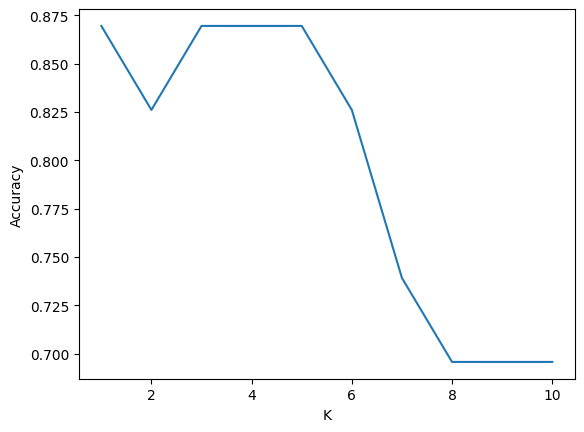

Accuracy for best value of k: 0.8695652173913043
Accuracy for k=1: 0.8695652173913043
Accuracy for k=2: 0.8260869565217391
Accuracy for k=3: 0.8695652173913043
Accuracy for k=4: 0.8695652173913043
Accuracy for k=5: 0.8695652173913043
Accuracy for k=6: 0.8260869565217391
Accuracy for k=7: 0.7391304347826086
Accuracy for k=8: 0.6956521739130435
Accuracy for k=9: 0.6956521739130435
Accuracy for k=10: 0.6956521739130435


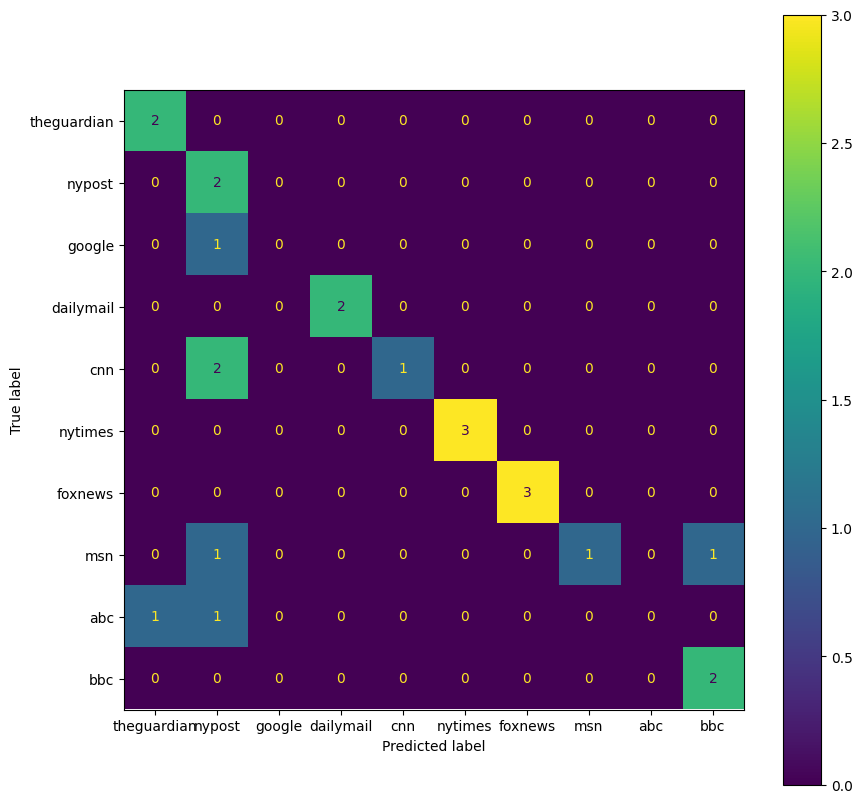

In [182]:
# Splitting the dataset into train and test sets with stratify since our dataset is small
X_train, X_test, y_train, y_test = train_test_split(df_scaled.iloc[:, :-1], df_scaled['label'], test_size=0.3, random_state=42, stratify=df_scaled['label'])

acc_scores = []
conf_matrices = []

for k in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc_scores.append(accuracy_score(y_test, y_pred))
    conf_matrices.append(confusion_matrix(y_test, y_pred))

# Plotting the accuracy-vs-K relation
plt.plot(range(1, 11), acc_scores)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.show()

# print the best value of k and its corresponding accuracy and confusion matrix
best_k = acc_scores.index(max(acc_scores)) + 1
print(f'Accuracy for best value of k: {acc_scores[best_k-1]}')

for k, acc in enumerate(acc_scores, start=1):
    print(f'Accuracy for k={k}: {acc}')

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=list(set(df_scaled["label"])))

# Create display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(label)))
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax)

# Show the plot
plt.show()

With comparing the results on the k-NN we see that for some of our websites (probably with the more accurate data gathering), We managed to reach a really good results. overall we got around 87% accuracy for different k. but for some other websites the answers were far away from the reality. A lot of the websites were predicted as nypost which can be investigated. 

## 4. Using an Alternate Test Set

In [204]:
alt_agg_df = pd.DataFrame()

# Using Iterrow is a sin but it is not so bad here since we only have 10 rows
for index, row in urls.iterrows():
  # Reading the corresponding file
  file_name = "da_" + row["label"] + ".csv"
  df = pd.read_csv(file_name)
  df = df[df["highest_layer"]=="TLS"]

  # Reading timestamps
  file_name = "ta_" + row["label"] + ".csv"
  tf_df = pd.read_csv(file_name)

  # Iterating through each request in our csv.
  for i in range(3):
    data = {"label": row["label"]}
    start_time = tf_df.iloc[i]["timestamp"]
    if i != 2:
      end_time = tf_df.iloc[i+1]["timestamp"]
      selected_df = df[
        (df["sniff_timestamp"] >= start_time) &
        (df["sniff_timestamp"] <= end_time)
        ]
    else:
      selected_df = df[df["sniff_timestamp"] >= start_time]

    # finding the most dominant flow
    dl_ip, ul_ip = dominant_flow_finder(selected_df)

    dom_ip = dl_ip

    # Calculating our biflow features (20 feats)
    # packet count
    data["packet_count_up"] = (selected_df["ip.dst"] == dom_ip).sum()
    data["packet_count_down"] = (selected_df["ip.src"] == dom_ip).sum()

    # total bytes
    data["total_bytes_up"] = selected_df.loc[selected_df["ip.dst"] == dom_ip, "length"].sum()
    data["total_bytes_down"] = selected_df.loc[selected_df["ip.src"] == dom_ip, "length"].sum()

    # min/max/mean/std packet size
    data["min_packet_size_up"] = selected_df[selected_df["ip.dst"] == dom_ip]["length"].min()
    data["min_packet_size_down"] = selected_df[selected_df["ip.src"] == dom_ip]["length"].min()

    data["max_packet_size_up"] = selected_df[selected_df["ip.dst"] == dom_ip]["length"].max()
    data["max_packet_size_down"] = selected_df[selected_df["ip.src"] == dom_ip]["length"].max()

    data["mean_packet_size_up"] = selected_df[selected_df["ip.dst"] == dom_ip]["length"].mean()
    data["mean_packet_size_down"] = selected_df[selected_df["ip.src"] == dom_ip]["length"].mean()

    data["std_packet_size_up"] = selected_df[selected_df["ip.dst"] == dom_ip]["length"].std()
    data["std_packet_size_down"] = selected_df[selected_df["ip.src"] == dom_ip]["length"].std()

    # iat values in ms
    iat = pd.to_datetime(selected_df[selected_df["ip.dst"] == dom_ip]['sniff_time']).diff(1).dt.total_seconds().iloc[1:] * 1000
    data['min_iat_up'] = iat.min()
    data['max_iat_up'] = iat.max()
    data['mean_iat_up'] = iat.mean()
    data['std_iat_up'] = iat.std()

    iat = pd.to_datetime(selected_df[selected_df["ip.src"] == dom_ip]['sniff_time']).diff(1).dt.total_seconds().iloc[1:] * 1000
    data['min_iat_down'] = iat.min()
    data['max_iat_down'] = iat.max()
    data['mean_iat_down'] = iat.mean()
    data['std_iat_down'] = iat.std()

    # create a dataframe from the dictionary since df.append is deprecated
    new_row = pd.DataFrame(data, index=[0])

    # concatenate the original dataframe and the new row dataframe
    alt_agg_df = pd.concat([alt_agg_df, new_row], ignore_index=True)

alt_agg_df

,label,packet_count_up,packet_count_down,total_bytes_up,total_bytes_down,min_packet_size_up,min_packet_size_down,max_packet_size_up,max_packet_size_down,mean_packet_size_up,...,std_packet_size_up,std_packet_size_down,min_iat_up,max_iat_up,mean_iat_up,std_iat_up,min_iat_down,max_iat_down,mean_iat_down,std_iat_down
0,nypost,0,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,nypost,3,6,926,5844,134.0,167.0,571.0,2698.0,308.666667,...,231.314360,973.788067,0.330,218.344,109.337000,154.159178,0.087,5.219,1.440800,2.125945
2,nypost,3,70,922,127168,134.0,167.0,571.0,5862.0,307.333333,...,232.082600,908.567666,0.242,222.938,111.590000,157.469852,0.000,6.603,0.301130,0.890510
3,abc,3,11,946,12028,130.0,100.0,583.0,1494.0,315.333333,...,237.458066,554.647161,0.228,215.498,107.863000,152.218877,0.312,199.950,21.665700,62.670450
4,abc,3,12,946,13483,130.0,212.0,583.0,1494.0,315.333333,...,237.458066,454.386591,0.264,215.188,107.726000,151.974218,0.000,5.949,1.168273,1.762807
5,abc,0,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,theguardian,6,30,1960,58326,130.0,90.0,583.0,9698.0,326.666667,...,208.600735,1989.279291,0.423,221.740,103.680000,110.597258,0.001,290.639,12.890241,53.566752
7,theguardian,6,22,1960,28706,130.0,90.0,583.0,4194.0,326.666667,...,208.600735,914.799517,0.419,222.243,106.230200,109.583806,0.123,314.817,33.732000,91.943030
8,theguardian,6,21,1960,35544,130.0,90.0,583.0,4194.0,326.666667,...,208.600735,1310.724249,0.358,216.254,102.084000,108.776101,0.001,312.148,34.504050,90.758711
9,bbc,3,29,945,68902,130.0,1442.0,583.0,2818.0,315.000000,...,237.632069,631.356755,0.562,219.441,110.001500,154.770825,0.000,13.502,2.892571,3.118865


We see that nypost, cnn and abc have problems even when we tried it another day.

In [205]:
alt_agg_df = alt_agg_df.dropna().reset_index(drop=True)

In [209]:
# Dropping the label from the df
new_label = alt_agg_df['label']
new_X = alt_agg_df.drop(['label'],axis=1)

# Scaling the features which is good for k-NN
new_X_scaled = scaler.fit_transform(new_X)

# Creating a new dataframe with the scaled features and the labels
new_df_scaled = pd.DataFrame(new_X_scaled, columns=alt_agg_df.columns[1:])
new_df_scaled["label"] = new_label


# encode the labels
new_df_scaled['label'] = label_encoder.fit_transform(new_df_scaled['label'])

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have v

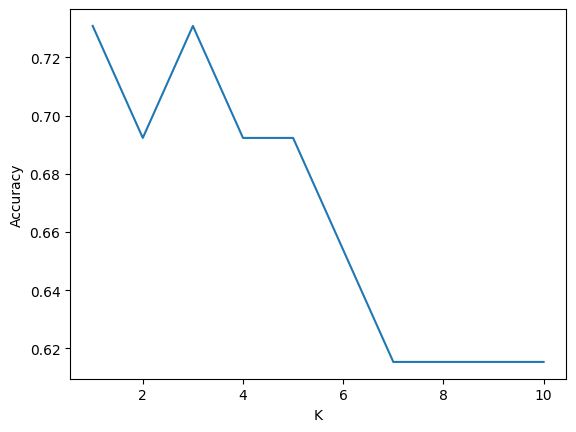

Accuracy for best value of k: 0.7307692307692307
Accuracy for k=1: 0.7307692307692307
Accuracy for k=2: 0.6923076923076923
Accuracy for k=3: 0.7307692307692307
Accuracy for k=4: 0.6923076923076923
Accuracy for k=5: 0.6923076923076923
Accuracy for k=6: 0.6538461538461539
Accuracy for k=7: 0.6153846153846154
Accuracy for k=8: 0.6153846153846154
Accuracy for k=9: 0.6153846153846154
Accuracy for k=10: 0.6153846153846154


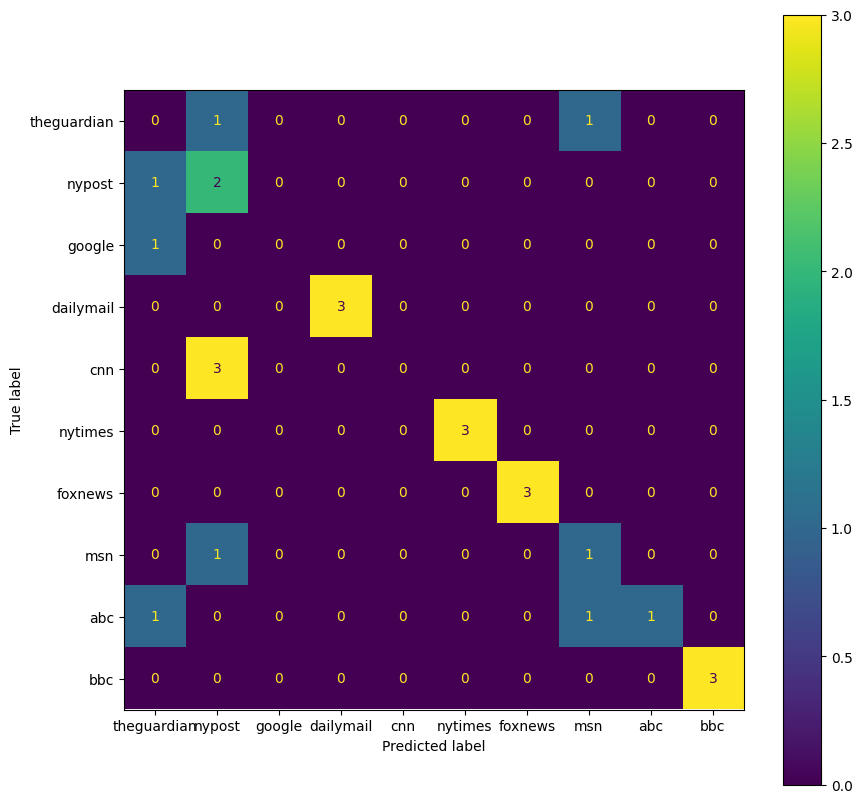

In [211]:
X_test = new_X_scaled
y_test = new_df_scaled['label']

acc_scores = []
conf_matrices = []

for k in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc_scores.append(accuracy_score(y_test, y_pred))
    conf_matrices.append(confusion_matrix(y_test, y_pred))

# Plotting the accuracy-vs-K relation
plt.plot(range(1, 11), acc_scores)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.show()

# print the best value of k and its corresponding accuracy and confusion matrix
best_k = acc_scores.index(max(acc_scores)) + 1
print(f'Accuracy for best value of k: {acc_scores[best_k-1]}')

for k, acc in enumerate(acc_scores, start=1):
    print(f'Accuracy for k={k}: {acc}')

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=list(set(new_df_scaled["label"])))

# Create display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(new_label)))
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax)

# Show the plot
plt.show()

As we check with the new test we see that for some of the websites that were performing well, for example foxnews and nytimes we continue to perform well. we see that our accuracy dropped by 15% but it is still a quite solid performance for new data (the new data has a 1 day difference).

For k to accuracy comparison we see the same trend goes for new test data.

Hessam Hashemizadeh